# 4 - Kramers chains (also known as bead-rod model)

Kramers chains are beads connected by rigid rods. Here, the connection is also a free hinge (no bending energy) and we neglect *excluded volume* energy and *hydrodynamic interactions*. We assume $N$ rods (numbered from $0$ to $N-1$, Python convention) of length $\ell$ connecting $N+1$ beads. The motion of each bead is governed by a stochastic differential equation:

\begin{equation}
\mathrm{d}X_i =\left(X_i\nabla U + \frac{g_i}{\zeta\ell} Q_i - \frac{g_{i-1}}{\zeta\ell}Q_{i-1}\right)\mathrm{d}t + \mathrm{d}W_i
\end{equation}

where $g_i$ is the tension in rod $i$ and with the convention $g_{-1}=g_{N}=0$ at chain ends, and $\mathrm{d}W_i$ are drawn from a normal distribution with zero mean and variance $2 kT \mathrm{d}t/\zeta$ per each coordinate. As in the case of dumbbells, we can get a system of equations for the rods $Q_i=X_{i+1}-X_i$:

\begin{equation}
\mathrm{d}Q_i =\left(Q_i\nabla U + \frac{g_{i-1}}{\zeta\ell}Q_{i-1} - 2\frac{g_i}{\zeta\ell} Q_i + \frac{g_{i+1}}{\zeta\ell}Q_{i+1}\right)\mathrm{d}t + \mathrm{d}W_{i+1}-\mathrm{d}W_{i}
\end{equation}

Note that here we cannot collapse $\mathrm{d}W_{i+1}-\mathrm{d}W_{i}$ into a single random variable since its value is correlated between neighbouring rods. The relaxation time for a rod is of the order of 

\begin{equation}
\tau = \frac{\zeta\ell^2}{kT}
\end{equation}

and we use this time scale and $\ell$ as the length scale to put equations in dimentionless form:

\begin{equation}
\mathrm{d}Q_i^+ =\left(Q_i^+(\nabla U)^+ + g_{i-1}^+Q_{i-1}^+ - 2g_i^+Q_i^+ + g_{i+1}^+Q_{i+1}^+\right)\mathrm{d}t^+ + \mathrm{d}W_{i+1}^+ -\mathrm{d}W_{i}^+
\end{equation}

where the dimensionless tension is $g_i^+=g_i\ell/(kT)$. Now the variance of $\mathrm{d}W_i^+$ is $2\mathrm{d}t^+$ in each coordinate. We don't know the tensions directly for the state of the system because there is no spring constant or force law, but we will get them by applying the rigidity constraint. Working now with dimensionless quantities but dropping the $^+$ symbol, rigidity can be written as:

\begin{equation}
(Q_i + \mathrm{d}Q_i)^2 = 1
\end{equation}

We develop to get the following tridiagonal system for the tensions:

\begin{equation}
- g_{i-1}Q_{i-1}\cdot Q_i + 2g_i - g_{i+1}Q_{i+1}\cdot Q_i =\left( Q_i\nabla U + \frac{\mathrm{d}W_{i+1} -\mathrm{d}W_{i}}{\mathrm{d}t}\right) \cdot Q_i + \frac{\mathrm{d}Q_i^2}{2\mathrm{d}t}
\end{equation}

The term $\mathrm{d}Q_i^2/2\mathrm{d}t$ is treated as an explicit term and the system is solved iteratively until the rod length is close to $1$ given a tolerance. We use the Lapack function `dptsv` wrapped in Scipy `linalg.lapack.dptsv` to solve this symmetric tridiagonal system.


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain

## Parameters definition

In [2]:
n_links = 100       # Number of segments in the Kramers chain

n_ensemble = 16     # Number of molecules to simulate
n_rec = 2000        # Number of time steps to record
dt = .001           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
seq = np.random.SeedSequence(2022)
seeds = seq.spawn(n_ensemble)
# Starting vectors
molecules = [KramersChain.from_normal_distribution(n_links, seed)
             for seed in seeds]

## Initial relaxation
Thermalisation step.

In [4]:
gradU = np.zeros((3, 3))
observables, molecules_out = simulate_batch(molecules, gradU, n_rec, dt, n_proc)

Physical time to compute: 2.0
Calculation started on 16 cores.


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


We can investigate the chains distribution.

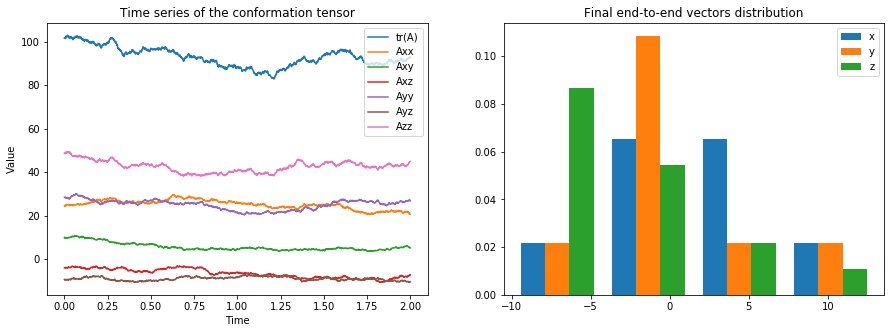

In [5]:
t = np.arange(n_rec)*dt
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [6]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          10] # Relaxation will start from t = 1
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [7]:
n_rec = 20_000
observables, molecules_out = simulate_batch(molecules_out, gradU, n_rec, dt, n_proc)

Physical time to compute: 20.0
Calculation started on 16 cores.


100%|██████████| 16/16 [01:35<00:00,  5.99s/it]


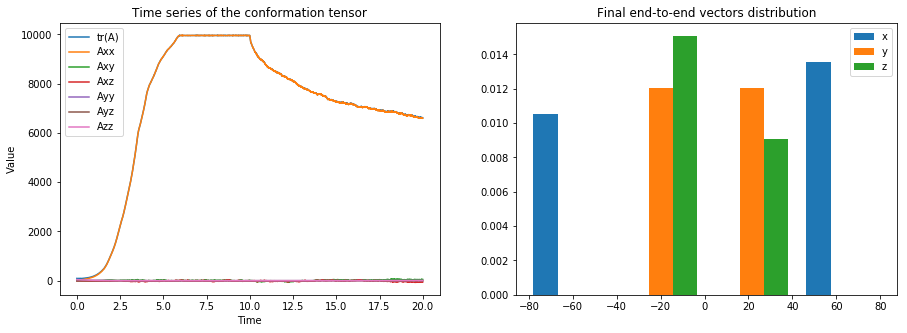

In [8]:
t = np.arange(n_rec)*dt
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

We can see that the average square length, tr(A), is constraint by (n_links)².

## Stress
We now examine the stress tensor.

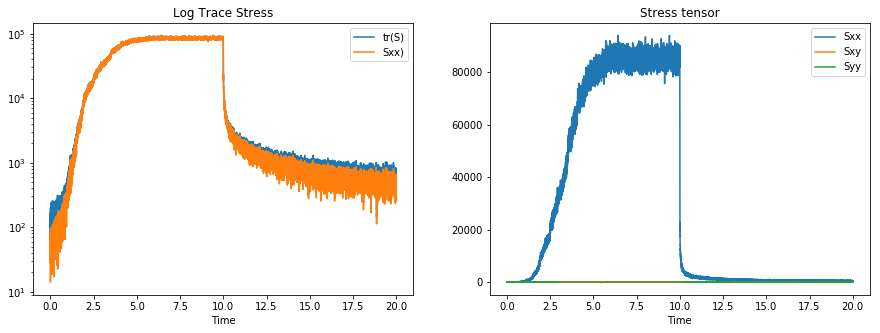

In [9]:
S = observables['S_average']
trS = np.trace(S, axis1=1, axis2=2)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].semilogy(t, trS, label='tr(S)')
ax[0].semilogy(t, S[:,0,0], label='Sxx)')
ax[0].set_title('Log Trace Stress')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].plot(t, S[:,0,0], label='Sxx')
ax[1].plot(t, S[:,0,1], label='Sxy')
ax[1].plot(t, S[:,1,1], label='Syy')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_title('Stress tensor')
plt.show()

A few remarks:
1. The stress is composed of a viscous part and visco-elastic part. When the flow is turned off, the viscous part vanishes instantaneously, while the viscoelastic part is relaxed over time.
2. The noise is very important with this estimator due to the rigid constaint.